# Titanic ML Project
##### A team project created by Devoney Brandon, Sawyer Redstone, Gloria Revanche, Bethany Rollen, Emily Speltz, and Christopher Velazco.

For this project, we will use machine learning to determine whether a passenger of the titanic most likely survived.

## Step 1. Import the necessary libraries:

In [1]:
import pandas as pd                                   # Data manipulation.
import matplotlib.pyplot as plt                       # Graphing capabilities.
import seaborn as sns                                 # More plots than plt and improved visuals.
from sklearn.tree import DecisionTreeClassifier       # Supervised machine learning algorithm.
from sklearn.tree import plot_tree                    # Decision Tree Visualization.
from sklearn.naive_bayes import GaussianNB            # Second supervised machine learning algorithm.
from sklearn.model_selection import train_test_split  # Split the data into training and testing subsets.
from sklearn.metrics import accuracy_score            # Check how accurate prediction is.
import joblib                                         # Save and load model.

# Display plots directly below code.
%matplotlib inline

## Step 2. Show the data:
We will use a dataset containing details on 891 of the Titanic passengers, along with whether each passenger survived. This will be used to train our model. The data can be seen below.

In [2]:
# Make a DataFrame from the training data, indexed by the Passenger ID.
training_data = pd.read_csv('train.csv', index_col = 'PassengerId')
training_data.head()    # Display the first 5 passengers.


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Step 3. Hypothesis:
We hypothesize that there are three contributing features to a passenger's survival: their sex, age, and socioeconomic status. 

The passenger's socioeconomic status can be determined by their passenger class (shown in the Pclass column), where 1 is upper class, 2 is middle class, and 3 is lower class.

We will use supervised learning for this test. 
<!-- This hypothesis only involves the Pclass and Survived columns, so we will make a clean version of the data that only contains these columns. -->

In [3]:
# Clean the data to only work with our hypothesized columns.
clean_data = training_data.loc[:, ["Survived", "Pclass", "Sex", "Age"]]

# Rename some column names and data for clarity.
clean_data.rename(columns={"Survived": "Life_Status", "Pclass": "Passenger_Class"}, inplace=True)
clean_data.Life_Status = clean_data.Life_Status.map({1:"Survived", 0:"Deceased"})

# Remove any columns that are missing values.
clean_data.dropna(inplace=True)
clean_data

,Life_Status,Passenger_Class,Sex,Age
PassengerId,,,,
1,Deceased,3,male,22.0
2,Survived,1,female,38.0
3,Survived,3,female,26.0
4,Survived,1,female,35.0
5,Deceased,3,male,35.0
...,...,...,...,...
886,Deceased,3,female,39.0
887,Deceased,2,male,27.0
888,Survived,1,female,19.0


## Step 4. Data Visualization:
Before testing our hypothesis, we will use data visualization to get a quick look at how our chosen features affect the rate of survival in passengers.

In [4]:
# Use the default Seaborn theme.
sns.set_theme()

# Set the palette to blues to represent the ocean where the ship sank.
sns.set_palette(["#03045E", "#48CAE4"])


#### Countplot

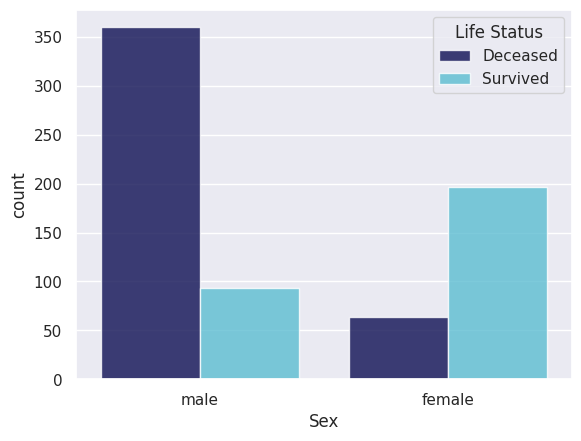

In [5]:
# Survivals between Sex.
sns.countplot(x = "Sex", hue = "Life_Status", data = clean_data, alpha=0.8)

plt.legend().set_title("Life Status")

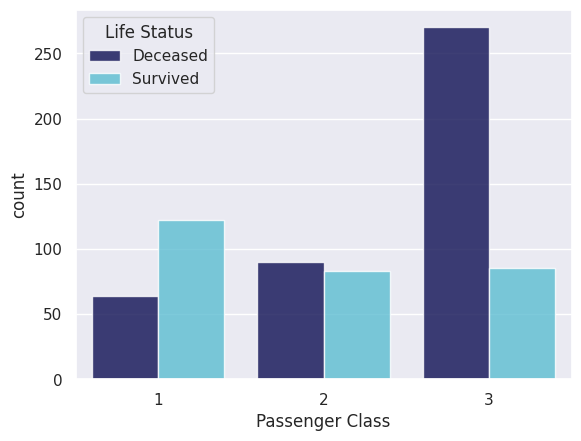

In [6]:
sns.countplot(x = "Passenger_Class", hue = "Life_Status", data = clean_data, alpha=0.8)

plt.xlabel("Passenger Class")
plt.legend().set_title("Life Status")

#### 100% Stacked Bar Chart

Text(0, 0.5, 'Proportion Survived')

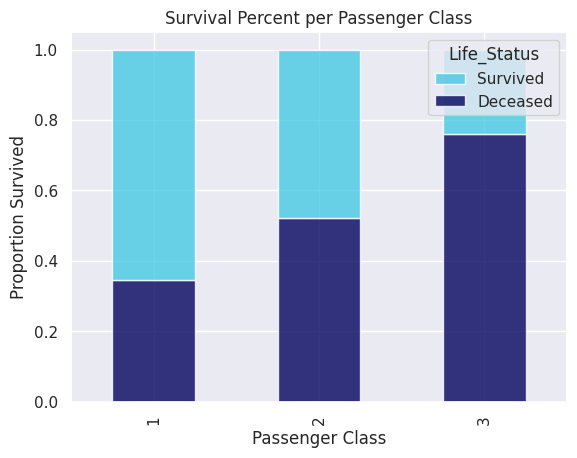

In [7]:
# Create a clean version of the data containing only survival and Pclass.
pclass_survival = clean_data.groupby("Passenger_Class").Life_Status

# Get percent that survived per passenger class.
survival_percent = pclass_survival.value_counts(normalize=True)

# Convert multi-indexed Series into a DataFrame.
survival_percent = survival_percent.unstack()

survival_percent.plot(kind="bar", stacked=True, alpha=0.8, legend='reverse')

plt.title("Survival Percent per Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Proportion Survived")


#### Violinplot

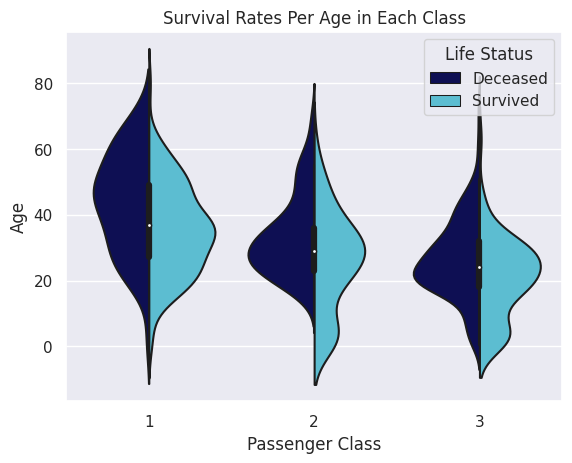

In [8]:
sns.violinplot(
    data=clean_data,
    x="Passenger_Class",
    y="Age",
    hue="Life_Status",
    split=True,
)

plt.title("Survival Rates Per Age in Each Class")
plt.xlabel("Passenger Class")
plt.legend().set_title("Life Status")



#### Stripplot

<AxesSubplot: xlabel='Passenger_Class', ylabel='Age'>

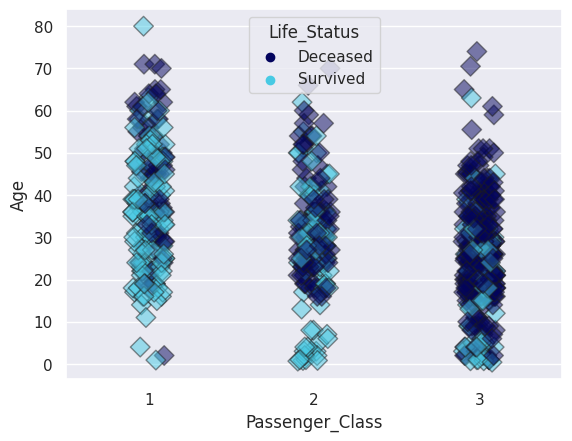

In [9]:
sns.stripplot(
    data=clean_data,
    x="Passenger_Class",
    y="Age",
    hue="Life_Status",
    s=10,                                 # Set size to 10.
    marker="D",                           # Make the markers diamond shapes.
    linewidth=1,                          # Give each marker an outline.
    alpha=.5,                             # Make it somewhat transparent so nothing is hidden from view.
    hue_order=["Deceased", "Survived"]    # Keep colors consistant by making Deceased darker.
)

<AxesSubplot: xlabel='Age', ylabel='Count'>

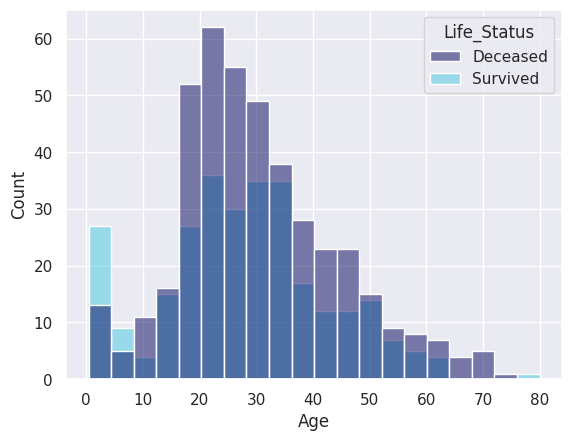

In [10]:
sns.histplot(clean_data, x="Age", hue="Life_Status")

## Step 5. Model Creation:
Now that we have seen how Sex, Pclass, and Age affect survival, we can clean our data and create models based on our hypothesis.

In [11]:
# Convert the Sex column into numbers for ease of use.
clean_data.Sex = clean_data.Sex.map({'male' : 1, 'female': 0})

# Revert the Life_Status column back to its original form of 0s and 1s.
clean_data.Life_Status = clean_data.Life_Status.map({"Survived":1, "Deceased":0})

# Set our predictor and criterion variables.
X = clean_data.drop(columns=["Life_Status"])
y = clean_data['Life_Status']

# We now split the data into two groups. 
# We will train on 80% of data and test our predictions on the remaining 20%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Decision Tree Model
First we will try the Decision Tree model.

In [12]:
# Create the model.
tree_model = DecisionTreeClassifier()

# Use our data to train the model.
tree_model.fit(X_train, y_train)

# Now that the model has been trained, we can use what was found to make predictions on the data.
tree_predictions = tree_model.predict(X_test) 

# Save our model for future use.
joblib.dump(tree_model, 'Tree_Predictor.joblib')  

# Check the accuracy of our model's prediction.
print("Model accuracy score:", accuracy_score(y_test, tree_predictions))

Model accuracy score: 0.8391608391608392


### Decision Tree Visualization
Below is a visualization of our model.

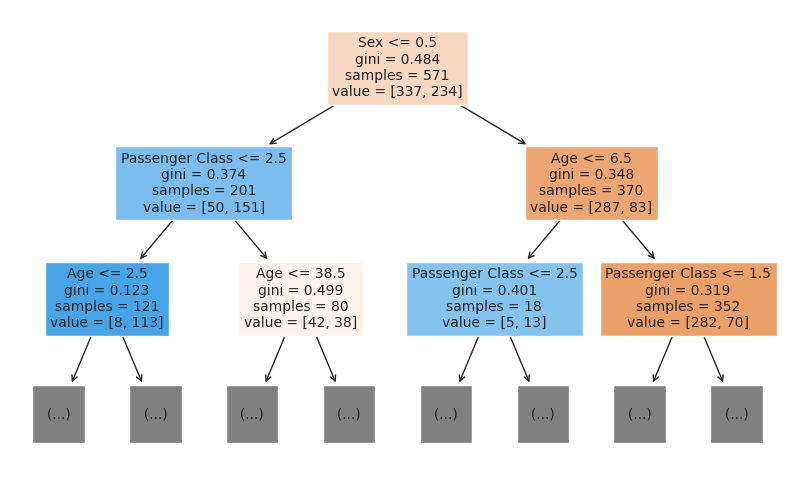

In [13]:
# Give the figure a width of 10 and height of 6.
plt.figure(figsize=(10, 6))

# Only visualize up to a depth of 2 to prevent screen cluttering.
plot_tree(tree_model, max_depth = 2, fontsize=10, filled=True, feature_names=["Passenger Class", "Sex", "Age"])

plt.show()

### Gaussian Naive Bayes model
We will now try a Gaussian Naive Bayes model so we can compare the resulting accuracy with our tree model.

In [14]:
# Create the model.
gaussian_model = GaussianNB()

# Use our data to train the model.
gaussian_model.fit(X_train, y_train)

# Now that the model has been trained, we can use what was found to make predictions on the data.
gaussian_predictions = gaussian_model.predict(X_test)

# Save our model for future use.
joblib.dump(gaussian_model, 'Gaussian_Predictor.joblib')

# Check the accuracy of our model's prediction.
print("Model accuracy score:", accuracy_score(y_test, gaussian_predictions)) 

Model accuracy score: 0.8321678321678322


## Step 6. Our Prediction:
Now that we have tested our hypothesis and seen how accurately it can make predictions, we are ready to apply our model to make predictions on the remaining data. 

We found that both models had similar accuracy scores. In the end, we decided to use the decision tree as our final model.

In [15]:
# Make the test data columns match the training data columns.
test_data = pd.read_csv('test.csv', index_col = 'PassengerId')
clean_test_data = test_data.loc[:, ["Pclass", "Sex", "Age"]]
clean_test_data.rename(columns={"Survived": "Life_Status", "Pclass": "Passenger_Class"}, inplace=True)
clean_test_data.Sex = clean_test_data.Sex.map({'male' : 1, 'female': 0})
clean_test_data.dropna(inplace=True)

# Make predictions on the test data using our model.
model = joblib.load('Tree_Predictor.joblib')

# Create a new column in test_data called Survival_Prediction that we fill with out predictions.
clean_test_data["Survival_Prediction"] = model.predict(clean_test_data)

# Like before, we will convert 0 to Deceased and 1 to Survived.
clean_test_data.Survival_Prediction = clean_test_data.Survival_Prediction.map({1:"Survived", 0:"Deceased"})


# Add our predictions as a column to the original test_data.
test_with_predictions = pd.concat([clean_test_data.Survival_Prediction, test_data], axis=1)
test_with_predictions

,Survival_Prediction,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
892,Deceased,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,Deceased,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,Survived,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,Survived,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,Survived,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,Survived,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,Deceased,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


## Step 7. Testing the accuracy of our prediction.
We were not given the ground truth of the survival of the remaining 418 passengers, so we cannot confirm how accurate our predictions were. Using visualization, however, we can see whether our predictions accurately show similar trends to the original data.

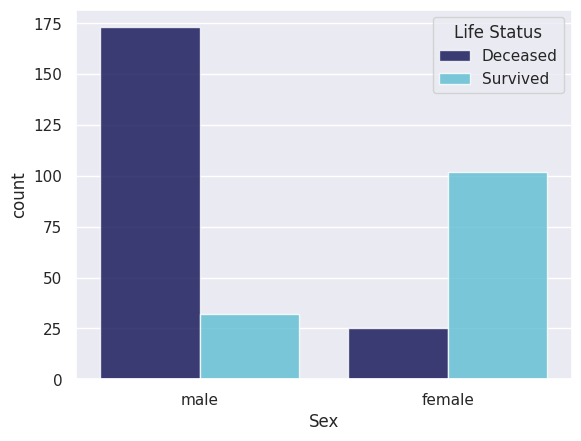

In [16]:
# Survivals between Sex.
sns.countplot(x = "Sex", hue = "Survival_Prediction", data = test_with_predictions, alpha=0.8)

plt.legend().set_title("Life Status")

<AxesSubplot: xlabel='Age', ylabel='Count'>

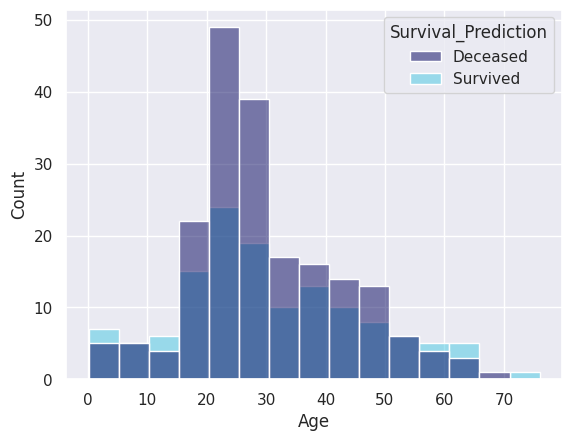

In [17]:
sns.histplot(test_with_predictions, x="Age", hue="Survival_Prediction")

### Success! 
Both charts have similar trends to our original data. From this it is shown that our predictions are reliable.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=84e56284-1821-4d1a-a80f-22e9f4c8d694' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>